# Bi-directional Recurrent Neural Network (LSTM) 外汇交易预测
基于 TensorFlow 2.0，Keras api 实现

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (16, 8)
summary_writer = tf.summary.create_file_writer('E:/Code/play_python/project/tensorboard')

## 读取数据

In [19]:
def data_loader():
    data_file="E:/Code/play_python/project/GBPUSD.pro1440.csv"
    raw_data = pd.read_csv(data_file, parse_dates=['Date'])
    return raw_data

In [20]:
# 加载数据
data = data_loader()
data

,Date,Time,Open,High,Low,Close,Volume
0,2012-01-20,00:00,1.54860,1.55770,1.54500,1.55740,79844
1,2012-01-23,00:00,1.55540,1.56010,1.55160,1.55650,82459
2,2012-01-24,00:00,1.55650,1.56250,1.55320,1.56240,76263
3,2012-01-25,00:00,1.56250,1.56780,1.55330,1.56570,84081
4,2012-01-26,00:00,1.56560,1.57330,1.56490,1.56880,77611
...,...,...,...,...,...,...,...
2043,2019-10-30,00:00,1.28682,1.29072,1.28377,1.28966,152018
2044,2019-10-31,00:00,1.28960,1.29756,1.28929,1.29405,167251
2045,2019-11-01,00:00,1.29402,1.29723,1.29239,1.29404,156924
2046,2019-11-04,00:00,1.29171,1.29424,1.28758,1.28814,133989


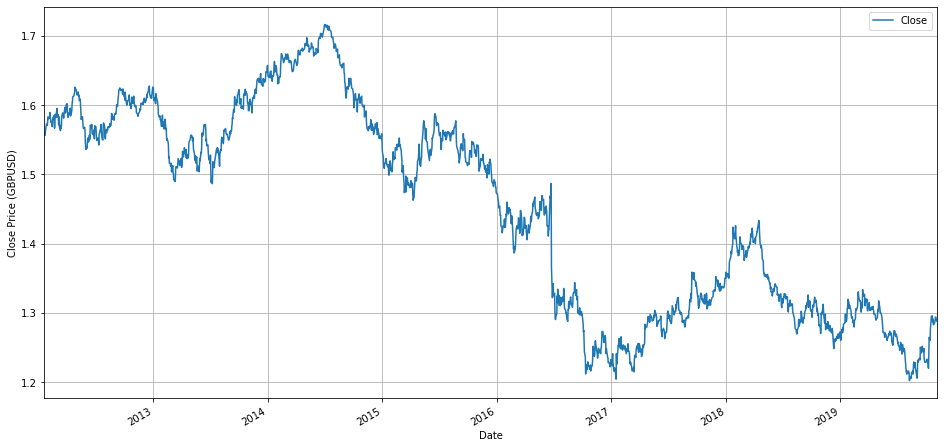

In [21]:
# Plot the Close Price Trend
ax = data.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (GBPUSD)")
plt.grid()

## 数据预处理

### 数据归一化

In [22]:
# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
close_price = data.Close.values.reshape(-1, 1)
close_data = scaler.fit_transform(close_price)
close_data

array([[0.69052157],
       [0.68877134],
       [0.70024503],
       ...,
       [0.17836724],
       [0.16689355],
       [0.16922718]])

### 定义数据序列化、分批
sequence

In [38]:
def make_sequence(data, seq_len):
    # Make sequence
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + seq_len
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X, np.float32), np.array(y, np.float32)
    
def split_sequence(data, seq_len, train_split):
    X, y = make_sequence(data, seq_len)

    # Split sequence into training data and testing data
    num_train = int(train_split * X.shape[0])
    X_train = X[:num_train]
    y_train = y[:num_train]
    X_test = X[num_train:]
    y_test = y[num_train:]
    return X_train, y_train, X_test, y_test

## 模型定义

In [45]:
class BiRNN(tf.keras.Model):
    def __init__(self, seq_length, n_features):
        super().__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        
        # Define 2 LSTM layers for forward and backward sequences.
        lstm_fw = tf.keras.layers.LSTM(units=self.seq_length)
        lstm_bw = tf.keras.layers.LSTM(units=self.seq_length, activation='relu', go_backwards=True)
        # BiRNN layer.
        self.bi_lstm = tf.keras.layers.Bidirectional(lstm_fw, backward_layer=lstm_bw)
        self.dense = tf.keras.layers.Dense(units=1)
    
    def call(self, inputs):
        x = self.bi_lstm(inputs)
        output = self.dense(x)
        return output

## 模型训练

### 定义一些超参数

In [46]:
SEQ_LEN = 100
n_features = 1

learning_rate = 0.001
EPOCH = 50
batch_size = 50

### 得到训练数据，测试数据

In [47]:
X_train, y_train, X_test, y_test = split_sequence(close_data, SEQ_LEN, train_split = 0.9)

### 执行训练

In [48]:
lstm_net = BiRNN(seq_length=SEQ_LEN, n_features=n_features)
optimizer = tf.optimizers.Adam(learning_rate)

In [49]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(100)

In [50]:
for epoch in range(1, EPOCH + 1):
    for X, y in train_data:
        with tf.GradientTape() as g:
            pred_y = lstm_net(X)
            loss = tf.keras.losses.MAE(y, pred_y)
            loss = tf.reduce_mean(loss)
        trainable_variables = lstm_net.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
    print("Epoch: %i, loss: %f" % (epoch, loss.numpy()))
    with summary_writer.as_default():                              
        tf.summary.scalar("loss", loss.numpy(), step=epoch)

Epoch: 1, loss: 0.079633
Epoch: 2, loss: 0.039185
Epoch: 3, loss: 0.036714
Epoch: 4, loss: 0.028087
Epoch: 5, loss: 0.022112
Epoch: 6, loss: 0.018506
Epoch: 7, loss: 0.024197
Epoch: 8, loss: 0.019193
Epoch: 9, loss: 0.021046
Epoch: 10, loss: 0.023906
Epoch: 11, loss: 0.021546
Epoch: 12, loss: 0.024216
Epoch: 13, loss: 0.019409
Epoch: 14, loss: 0.019620
Epoch: 15, loss: 0.021276
Epoch: 16, loss: 0.019212
Epoch: 17, loss: 0.018775
Epoch: 18, loss: 0.019062
Epoch: 19, loss: 0.021809
Epoch: 20, loss: 0.015341
Epoch: 21, loss: 0.017738
Epoch: 22, loss: 0.016073
Epoch: 23, loss: 0.018475
Epoch: 24, loss: 0.017758
Epoch: 25, loss: 0.014432
Epoch: 26, loss: 0.015597
Epoch: 27, loss: 0.020029
Epoch: 28, loss: 0.018038
Epoch: 29, loss: 0.014964
Epoch: 30, loss: 0.015861
Epoch: 31, loss: 0.016934
Epoch: 32, loss: 0.016837
Epoch: 33, loss: 0.019564
Epoch: 34, loss: 0.014023
Epoch: 35, loss: 0.015763
Epoch: 36, loss: 0.016820
Epoch: 37, loss: 0.014973
Epoch: 38, loss: 0.015684
Epoch: 39, loss: 0.01

## 进行验证

In [51]:
y_hat = lstm_net.predict(X_test)
loss = tf.reduce_mean(tf.keras.losses.MAE(y_test, y_hat))
loss.numpy()

0.014932616

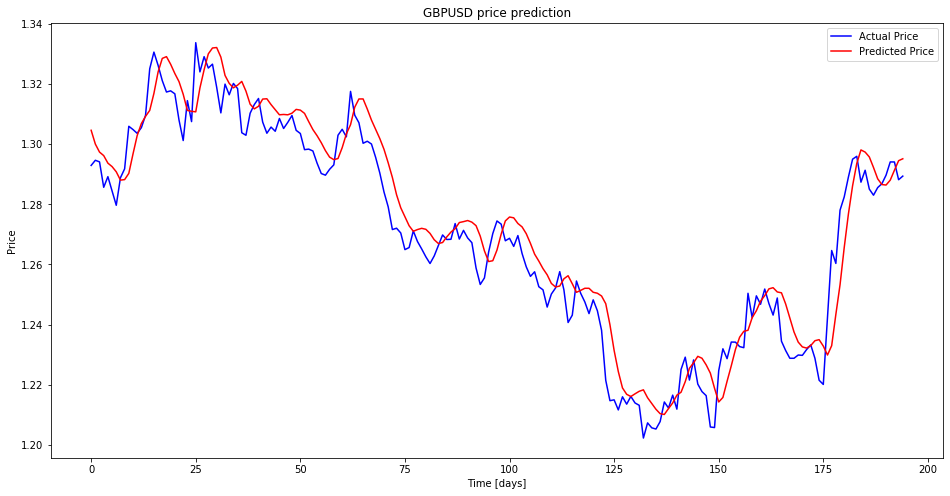

In [52]:
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='blue')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
plt.title('GBPUSD price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()